In [1]:
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (64,64)

data_dir = "C:/Users/DELL/OneDrive/Desktop/ASL_Detection/Data/asl_dataset"

train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode = 'int', #
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = "training",
    seed = 123
)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode = 'int',
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = "validation",
    seed = 123
)

Found 2515 files belonging to 36 classes.
Using 2012 files for training.
Found 2515 files belonging to 36 classes.
Using 503 files for validation.


In [2]:
class_names = train_set.class_names
print(class_names)  # ['a', 'b', ..., 'z']

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
import os

for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        print(f"{class_name}: {num_files} files")

0: 70 files
1: 70 files
2: 70 files
3: 70 files
4: 70 files
5: 70 files
6: 70 files
7: 70 files
8: 70 files
9: 70 files
a: 70 files
b: 70 files
c: 70 files
d: 70 files
e: 70 files
f: 70 files
g: 70 files
h: 70 files
i: 70 files
j: 70 files
k: 70 files
l: 70 files
m: 70 files
n: 70 files
o: 70 files
p: 70 files
q: 70 files
r: 70 files
s: 70 files
t: 65 files
u: 70 files
v: 70 files
w: 70 files
x: 70 files
y: 70 files
z: 70 files


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [5]:
from tensorflow.keras import layers, models

# Create an improved model with regularization techniques
model = models.Sequential([
    layers.Conv2D(32, (3,3), strides=2, activation="relu", input_shape=(64, 64, 3)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), strides=2, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3,3), activation="relu"),
    
    # Replace Flatten + Dense with GlobalAveragePooling2D
    layers.GlobalAveragePooling2D(),  # Magic happens here!
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 31, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,892 (382.39 KB)

 Trainable params: 97,892 (382.39 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0709 - loss: 3.4544 - val_accuracy: 0.4016 - val_loss: 2.0528
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4337 - loss: 1.8484 - val_accuracy: 0.7435 - val_loss: 0.7745
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6748 - loss: 0.9693 - val_accuracy: 0.8290 - val_loss: 0.4986
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7812 - loss: 0.6454 - val_accuracy: 0.8688 - val_loss: 0.3687
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8284 - loss: 0.4926 - val_accuracy: 0.8569 - val_loss: 0.3725
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8576 - loss: 0.4057 - val_accuracy: 0.9066 - val_loss: 0.2608
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8835 - loss: 0.3598 - val_accuracy: 0.9185 - val_loss: 0.2261
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8914 - loss: 0.2900 - val_accuracy: 0.9245 - val_loss: 0.2054
Ep

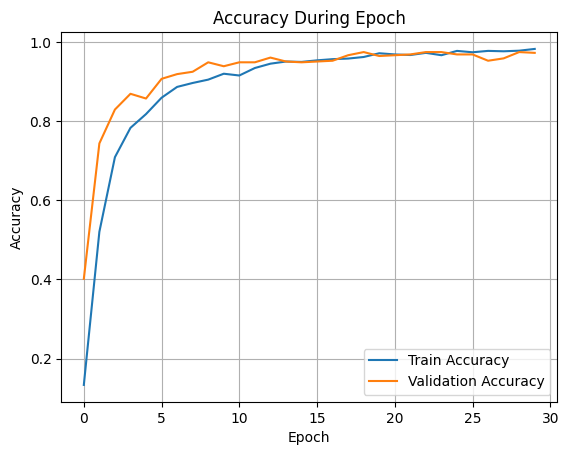

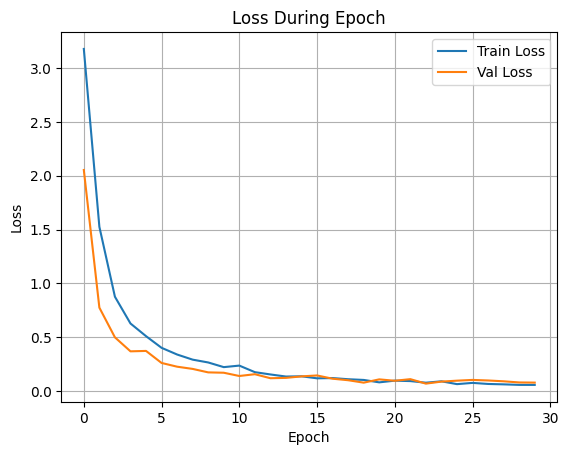

In [7]:
import matplotlib.pyplot as plt

# Accuracy\
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Epoch')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss During Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Check test accuracy

In [8]:
test_set = tf.keras.utils.image_dataset_from_directory(
    "C:/Users/DELL/OneDrive/Desktop/ASL_Detection/Data/test",
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123,
    shuffle=False
)

# Apply same preprocessing as training
test_ds = test_set.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Now evaluate again
test_loss, test_acc = model.evaluate(test_ds)
print(f"🎯 Accuracy on test set: {test_acc:.2%}")

Found 896 files belonging to 36 classes.
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4138 - loss: 8.0778
🎯 Accuracy on test set: 16.41%


In [9]:
metrics = history.history
final_metrics = {key: values[-1] for key, values in metrics.items()}

print(final_metrics)

# Save metrics to JSON file
import json
from pathlib import Path

final_metrics["model_name"] = "nguyen tuan dung's model"

results_path = Path("C:/Users/DELL/OneDrive/Desktop/ASL_Detection/Results")/"ntd_model.json"
results_path.parent.mkdir(exist_ok=True)

with open(results_path, "w") as f:
  json.dump(final_metrics, f, indent=4)

print(f"Saved results to {results_path}")

{'accuracy': 0.9821073412895203, 'loss': 0.056763291358947754, 'val_accuracy': 0.9721670150756836, 'val_loss': 0.07825049757957458}
Saved results to C:\Users\DELL\OneDrive\Desktop\ASL_Detection\Results\ntd_model.json
